In [1]:
import torch, math
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.modules.transformer import TransformerEncoderLayer
from Components.positionalEncoding import PositionalEncoding

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda")

In [ ]:
# Get a noisy sin wave
DATA_SIZE = 1000
x = np.sin(np.linspace(0, 10, DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)

# Create a dataset
seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])

# Setup data loaders for batch
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [35]:
# Positional Encoding - https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model: int, seq_len: int = 5000, dropout: float = 0.1):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         position = torch.arange(seq_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(seq_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)
#     def forward(self, x: Tensor) -> Tensor:
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

In [3]:
# A basic attention mechanism
# class Attention(torch.nn.Module):
#     def __init__(self, seq_len=200, device=device):
#         super(Attention, self).__init__()
#         self.device=device
#         self.queries = nn.Linear(seq_len, seq_len)
#         self.keys = nn.Linear(seq_len, seq_len)
#         self.values = nn.Linear(seq_len, seq_len)
#     def forward(self, x, mask=True):
#         q = self.queries(x).reshape(x.shape[0], x.shape[1], 1)
#         k = self.keys(x).reshape(x.shape[0], x.shape[1], 1)
#         v = self.values(x).reshape(x.shape[0], x.shape[1], 1)
#         scores = torch.bmm(q, k.transpose(-2, -1))
#         if mask:
#             maskmat = torch.tril(torch.ones((x.shape[1], x.shape[1]))).to(self.device)
#             scores = scores.masked_fill(maskmat == 0, -1e9)
#         attention_weights = F.softmax(scores, dim=-1)
#         output = torch.bmm(attention_weights, v)
#         return output.reshape(output.shape[0], output.shape[1])


# A forcasting model
# class ForecastingModel(torch.nn.Module):
#     def __init__(self, seq_len=200, ffdim=64, device=device):
#         super(ForecastingModel, self).__init__()
#         self.relu = nn.ReLU()
#         self.attention = Attention(seq_len, device=device)
#         self.linear1 = nn.Linear(seq_len, int(ffdim))
#         self.linear2 = nn.Linear(int(ffdim), int(ffdim/2))
#         self.linear3 = nn.Linear(int(ffdim/2), int(ffdim/4))
#         self.outlayer = nn.Linear(int(ffdim/4), 1)
#     def forward(self, x):
#         x = self.attention(x)
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.linear3(x)
#         x = self.relu(x)
#         return self.outlayer(x)

In [4]:
# # A forcasting model
# class ForecastingModel(torch.nn.Module):
#     def __init__(self, 
#                  seq_len=200,
#                  embed_size = 16,
#                  nhead = 4,
#                  dim_feedforward = 2048,
#                  dropout = 0.1,
#                  conv1d_emb = True,
#                  conv1d_kernel_size = 3,
#                  device = device):
#         super(ForecastingModel, self).__init__()

#         # Set Class-level Parameters
#         self.device = device
#         self.conv1d_emb = conv1d_emb
#         self.conv1d_kernel_size = conv1d_kernel_size
#         self.seq_len = seq_len
#         self.embed_size = embed_size

#         # Input Embedding Component
#         if conv1d_emb:
#             if conv1d_kernel_size%2==0:
#                 raise Exception("conv1d_kernel_size must be an odd number to preserve dimensions.")
#             self.conv1d_padding = conv1d_kernel_size - 1
#             self.input_embedding  = nn.Conv1d(1, embed_size, kernel_size=conv1d_kernel_size)
#         else: self.input_embedding  = nn.Linear(1, embed_size)

#         # Positional Encoder Componet (See Code Copied from PyTorch Above)
#         self.position_encoder = PositionalEncoding(d_model=embed_size, 
#                                                    seq_len=seq_len,
#                                                    dropout=dropout)
        
#         # Transformer Encoder Layer Component
#         self.transformer_encoder = TransformerEncoderLayer(
#             d_model = embed_size,
#             nhead = nhead,
#             dim_feedforward = dim_feedforward,
#             dropout = dropout,
#             batch_first = True
#         )

#         # Regression Component
#         self.linear1 = nn.Linear(seq_len*embed_size, int(dim_feedforward))
#         self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
#         self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
#         self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
#         self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
#         self.outlayer = nn.Linear(int(dim_feedforward/64), 1)

#         # Basic Components
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)

#     # Model Forward Pass
#     def forward(self, x):
#         src_mask = self._generate_square_subsequent_mask()
#         src_mask.to(self.device)
#         if self.conv1d_emb: 
#             x = F.pad(x, (0, 0, self.conv1d_padding, 0), "constant", -1)
#             x = self.input_embedding(x.transpose(1, 2))
#             x = x.transpose(1, 2)
#         else: 
#             x = self.input_embedding(x)
#         x = self.position_encoder(x)
#         x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len*self.embed_size))
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear4(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear5(x)
#         x = self.relu(x)
#         return self.outlayer(x)
    
#     # Function Copied from PyTorch Library to create upper-triangular source mask
#     def _generate_square_subsequent_mask(self):
#         return torch.triu(
#             torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
#             diagonal=1,
#         )

/Users/ncng/.local/share/virtualenvs/transformers-wh7nYgOz/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20: Loss=0.4533825218677521
Epoch 2/20: Loss=0.4428059458732605
Epoch 3/20: Loss=0.4161183536052704
Epoch 4/20: Loss=0.26833006739616394
Epoch 5/20: Loss=0.07883670926094055
Epoch 6/20: Loss=0.01746058650314808
Epoch 7/20: Loss=0.008553719148039818
Epoch 8/20: Loss=0.006811048835515976
Epoch 9/20: Loss=0.004036684986203909
Epoch 10/20: Loss=0.0035444647073745728
Epoch 11/20: Loss=0.0029537652153521776
Epoch 12/20: Loss=0.002957336138933897
Epoch 13/20: Loss=0.0032136966474354267
Epoch 14/20: Loss=0.00327086728066206
Epoch 15/20: Loss=0.0037024770863354206
Epoch 16/20: Loss=0.0034582363441586494
Epoch 17/20: Loss=0.0033971983939409256
Epoch 18/20: Loss=0.0031121482606977224
Epoch 19/20: Loss=0.0030951446387916803
Epoch 20/20: Loss=0.003010160755366087


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ncng/Documents/Projects/transformers/classical/img/sine_example.png'

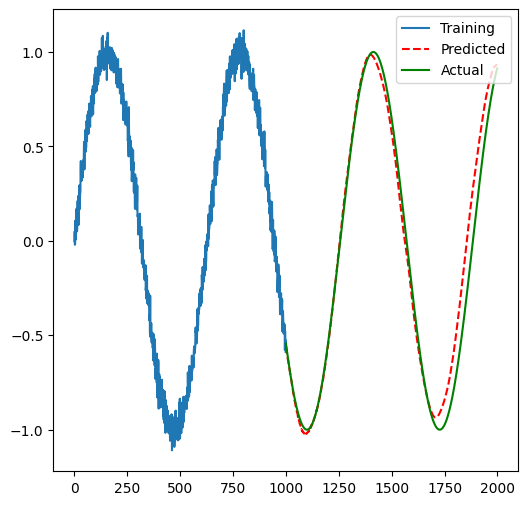

In [5]:
# # Get a noisy sin wave
# DATA_SIZE = 1000
# x = np.sin(np.linspace(0, 10, DATA_SIZE))
# x = x + np.random.normal(0, 0.05, DATA_SIZE)


# # Create a dataset
# seq_len = 200
# X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])
# Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])


# # Training Loop
# EPOCHS = 20
# BATCH_SIZE = 8
# LEARNING_RATE = 4.12e-5
# model = ForecastingModel(seq_len)
# model.to(device)
# model.train()
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
# for epoch in range(EPOCHS):
#     for xx, yy in dataloader:
#         optimizer.zero_grad()
#         out = model(xx)
#         loss = criterion(out, yy)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


# # New Prediction Loop
# FORCAST = 1000
# model.eval()
# for ff in range(FORCAST):
#     xx = x[len(x)-seq_len:len(x)]
#     yy = model(torch.Tensor(xx).reshape(1, xx.shape[0]).to(device))
#     x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# # Plot Predictions
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(6, 6))
# plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
# plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
# plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
# plt.legend()

In [5]:
# Get a noisy sin wave
# DATA_SIZE = 1000
# x = np.sin(np.linspace(0, 10, DATA_SIZE))
# x = x + np.random.normal(0, 0.05, DATA_SIZE)


# # Create a dataset
# seq_len = 200
# X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
# Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))


In [6]:
# # Training Loop
# EPOCHS = 30
# BATCH_SIZE = 1
# LEARNING_RATE = 2.2e-6
# model = ForecastingModel(seq_len, embed_size=8, nhead=2, dim_feedforward=1024, dropout=0, device=device)
# model.to(device)
# model.train()
# criterion = torch.nn.HuberLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
# dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
# for epoch in range(EPOCHS):
#     for xx, yy in dataloader:
#         optimizer.zero_grad()
#         out = model(xx)
#         loss = criterion(out, yy)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()
#     print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


Epoch 1/30: Loss=0.05766783282160759
Epoch 2/30: Loss=0.058429788798093796
Epoch 3/30: Loss=0.05908561870455742
Epoch 4/30: Loss=0.059571605175733566
Epoch 5/30: Loss=0.06005067750811577
Epoch 6/30: Loss=0.06049366295337677
Epoch 7/30: Loss=0.060906294733285904
Epoch 8/30: Loss=0.06125342845916748
Epoch 9/30: Loss=0.06157529726624489
Epoch 10/30: Loss=0.06186402589082718
Epoch 11/30: Loss=0.062120452523231506
Epoch 12/30: Loss=0.06237190589308739
Epoch 13/30: Loss=0.06259256601333618
Epoch 14/30: Loss=0.0627969279885292
Epoch 15/30: Loss=0.06297573447227478
Epoch 16/30: Loss=0.06313829869031906
Epoch 17/30: Loss=0.06328185647726059
Epoch 18/30: Loss=0.06342093646526337
Epoch 19/30: Loss=0.063533715903759
Epoch 20/30: Loss=0.06363875418901443
Epoch 21/30: Loss=0.06373975425958633
Epoch 22/30: Loss=0.06382766366004944
Epoch 23/30: Loss=0.0639089047908783
Epoch 24/30: Loss=0.06397899985313416
Epoch 25/30: Loss=0.06404168158769608
Epoch 26/30: Loss=0.06410211324691772
Epoch 27/30: Loss=0.0

In [14]:
# # Prediction Loop
# FORCAST = 1000
# model.eval()
# for ff in range(FORCAST):
#     xx = x[len(x)-seq_len:len(x)]
#     yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
#     x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


ValueError: x and y must have same first dimension, but have shapes (4000,) and (1000,)

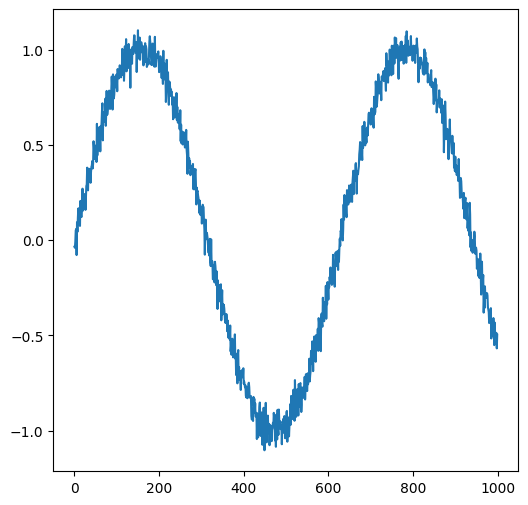

In [31]:
# # Plot Predictions
# fig = plt.figure(figsize=(6, 6))
# plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
# plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
# plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
# plt.legend()